# Data Pipeline: Quality & Bias Assessment

This notebook assesses the data pipeline from sampling through annotation, checking for:
- Sampling representativeness
- Street View coverage gaps
- Annotation completion and potential biases

In [1]:
import json
import re
from pathlib import Path

import folium
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

pd.set_option("display.max_columns", None)
sns.set_theme(style="whitegrid")

In [2]:
DATA_DIR = Path("..") / "data"
ANNOTATIONS_DIR = DATA_DIR / "annotations"
OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

## Section 1: Sampling

Analysis of the initial sampling from OpenStreetMap road segments.

In [3]:
locations_df = pd.read_csv(DATA_DIR / "samples" / "all_cities.csv")
print(f"Total sampled locations: {len(locations_df):,}")
print(f"\nLocations per city:")
locations_df["city"].value_counts()

Total sampled locations: 7,000

Locations per city:


city
Mumbai         2500
Delhi          2500
Navi Mumbai    2000
Name: count, dtype: int64

In [4]:
print("Road type distribution of sampled locations:")
road_dist = locations_df["osm_type"].value_counts()
road_pct = (road_dist / len(locations_df) * 100).round(1)
pd.DataFrame({"count": road_dist, "pct": road_pct})

Road type distribution of sampled locations:


count   pct
osm_type                 
residential    5184  74.1
tertiary        902  12.9
secondary       480   6.9
primary         279   4.0
unclassified    155   2.2

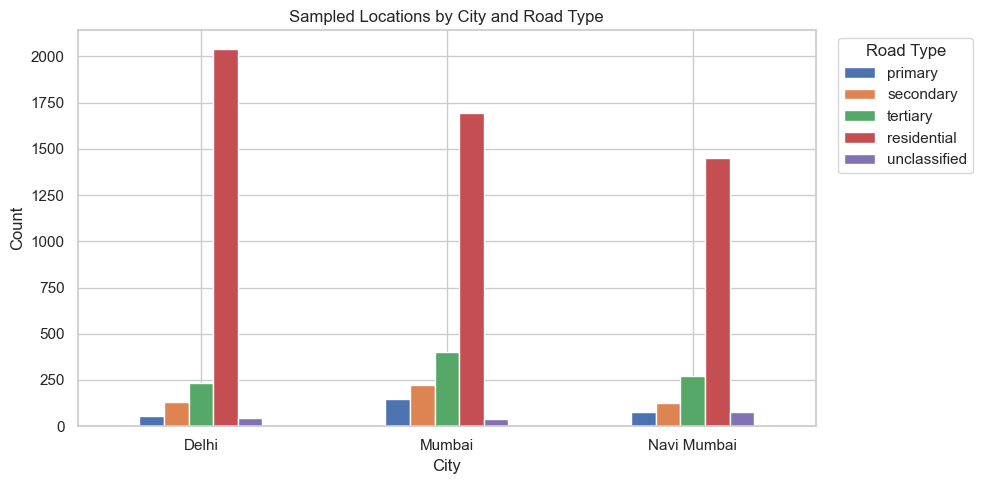

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
road_order = ["primary", "secondary", "tertiary", "residential", "unclassified"]
road_by_city = locations_df.groupby(["city", "osm_type"]).size().unstack(fill_value=0)
road_by_city = road_by_city[[c for c in road_order if c in road_by_city.columns]]
road_by_city.plot(kind="bar", ax=ax)
ax.set_ylabel("Count")
ax.set_xlabel("City")
ax.set_title("Sampled Locations by City and Road Type")
ax.legend(title="Road Type", bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "sampling_by_city_road.png", dpi=150, bbox_inches="tight")
plt.show()

## Section 2: Street View Coverage

Analysis of Google Street View coverage for sampled locations.

In [6]:
coverage_df = pd.read_csv(DATA_DIR / "coverage" / "random_sample_coverage.csv")
print(f"Total locations checked: {len(coverage_df):,}")
print(f"\nCoverage status:")
coverage_df["has_coverage"].value_counts()

Total locations checked: 4,500

Coverage status:


has_coverage
True     3551
False     949
Name: count, dtype: int64

In [7]:
coverage_merged = coverage_df.merge(locations_df[["location_id", "osm_type"]], on="location_id", how="left")

coverage_by_city = coverage_merged.groupby("city")["has_coverage"].agg(["sum", "count"])
coverage_by_city["rate"] = (coverage_by_city["sum"] / coverage_by_city["count"] * 100).round(1)
coverage_by_city.columns = ["with_coverage", "total", "rate_pct"]
print("Coverage rate by city:")
coverage_by_city

Coverage rate by city:


with_coverage  total  rate_pct
city                                       
Delhi                 1171   1500      78.1
Mumbai                1246   1500      83.1
Navi Mumbai           1134   1500      75.6

In [8]:
coverage_by_road = coverage_merged.groupby("osm_type")["has_coverage"].agg(["sum", "count"])
coverage_by_road["rate"] = (coverage_by_road["sum"] / coverage_by_road["count"] * 100).round(1)
coverage_by_road.columns = ["with_coverage", "total", "rate_pct"]
print("Coverage rate by road type:")
coverage_by_road.reindex([r for r in road_order if r in coverage_by_road.index])

Coverage rate by road type:


with_coverage  total  rate_pct
osm_type                                    
primary                 155    162      95.7
secondary               296    305      97.0
tertiary                544    588      92.5
residential            2492   3339      74.6
unclassified             64    106      60.4

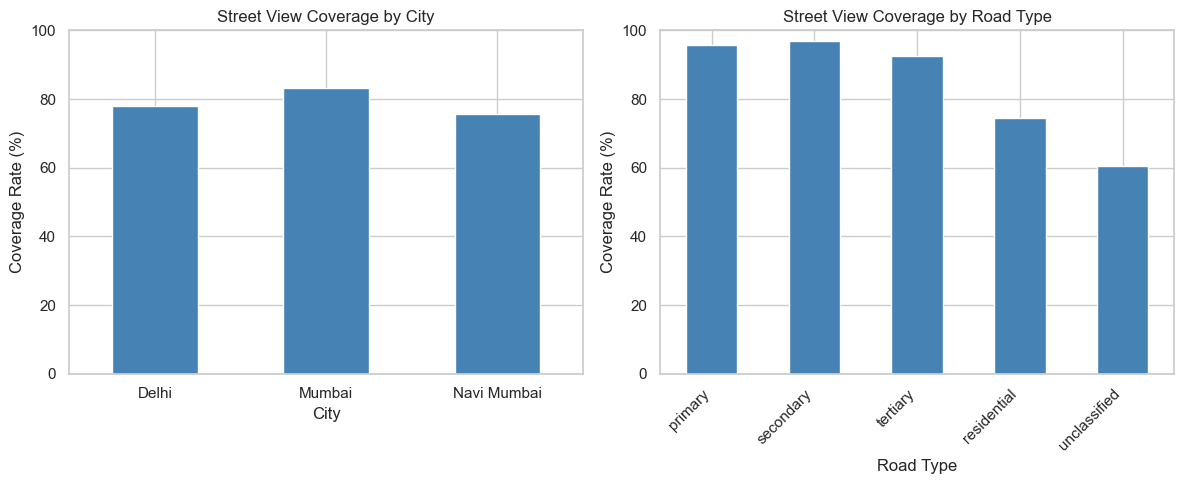

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
coverage_by_city["rate_pct"].plot(kind="bar", ax=ax1, color="steelblue")
ax1.set_ylabel("Coverage Rate (%)")
ax1.set_xlabel("City")
ax1.set_title("Street View Coverage by City")
ax1.set_ylim(0, 100)
plt.sca(ax1)
plt.xticks(rotation=0)

ax2 = axes[1]
road_order_present = [r for r in road_order if r in coverage_by_road.index]
coverage_by_road.loc[road_order_present, "rate_pct"].plot(kind="bar", ax=ax2, color="steelblue")
ax2.set_ylabel("Coverage Rate (%)")
ax2.set_xlabel("Road Type")
ax2.set_title("Street View Coverage by Road Type")
ax2.set_ylim(0, 100)
plt.sca(ax2)
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "coverage_rates.png", dpi=150, bbox_inches="tight")
plt.show()

## Section 3: Annotation Completion

Comparison of sampled, covered, and annotated locations to detect potential biases.

In [10]:
def extract_location_id(image_path: str) -> str:
    match = re.search(r"(loc_\d+)_h\d+_p[+-]?\d+\.jpg", image_path)
    if match:
        return match.group(1)
    return None

ls_files = list(ANNOTATIONS_DIR.glob("*_v2.json"))
print(f"Found {len(ls_files)} Label Studio export file(s)")

with open(ls_files[0]) as f:
    ls_data = json.load(f)

annotated_location_ids = set()
for task in ls_data:
    image_path = task.get("data", {}).get("image", "")
    loc_id = extract_location_id(image_path)
    if loc_id:
        annotated_location_ids.add(loc_id)

print(f"Total annotated tasks: {len(ls_data)}")
print(f"Unique annotated locations: {len(annotated_location_ids)}")

Found 1 Label Studio export file(s)
Total annotated tasks: 1942
Unique annotated locations: 1435


In [11]:
locations_df["annotated"] = locations_df["location_id"].isin(annotated_location_ids)
locations_df["has_coverage"] = locations_df["location_id"].isin(
    coverage_df[coverage_df["has_coverage"]]["location_id"]
)

funnel = pd.DataFrame({
    "stage": ["Sampled", "With Coverage", "Annotated"],
    "count": [
        len(locations_df),
        locations_df["has_coverage"].sum(),
        locations_df["annotated"].sum()
    ]
})
funnel["pct_of_sampled"] = (funnel["count"] / funnel["count"].iloc[0] * 100).round(1)
print("Pipeline funnel:")
funnel

Pipeline funnel:


stage  count  pct_of_sampled
0        Sampled   7000           100.0
1  With Coverage   3551            50.7
2      Annotated   1435            20.5

In [12]:
funnel_by_city = locations_df.groupby("city").agg(
    sampled=("location_id", "count"),
    with_coverage=("has_coverage", "sum"),
    annotated=("annotated", "sum")
).astype(int)
funnel_by_city["coverage_rate"] = (funnel_by_city["with_coverage"] / funnel_by_city["sampled"] * 100).round(1)
funnel_by_city["annotation_rate"] = (funnel_by_city["annotated"] / funnel_by_city["with_coverage"] * 100).round(1)
print("Pipeline funnel by city:")
funnel_by_city

Pipeline funnel by city:


sampled  with_coverage  annotated  coverage_rate  annotation_rate
city                                                                          
Delhi           2500           1171        500           46.8             42.7
Mumbai          2500           1246        498           49.8             40.0
Navi Mumbai     2000           1134        437           56.7             38.5

In [13]:
sampled_road_dist = locations_df["osm_type"].value_counts(normalize=True) * 100
annotated_road_dist = locations_df[locations_df["annotated"]]["osm_type"].value_counts(normalize=True) * 100

road_comparison = pd.DataFrame({
    "sampled_pct": sampled_road_dist,
    "annotated_pct": annotated_road_dist
}).round(1)
road_comparison["diff"] = (road_comparison["annotated_pct"] - road_comparison["sampled_pct"]).round(1)
print("Road type distribution: Sampled vs Annotated")
print("(positive diff = over-represented in annotations)")
road_comparison.reindex([r for r in road_order if r in road_comparison.index])

Road type distribution: Sampled vs Annotated
(positive diff = over-represented in annotations)


sampled_pct  annotated_pct  diff
osm_type                                      
primary               4.0            4.4   0.4
secondary             6.9            8.4   1.5
tertiary             12.9           15.0   2.1
residential          74.1           69.9  -4.2
unclassified          2.2            2.4   0.2

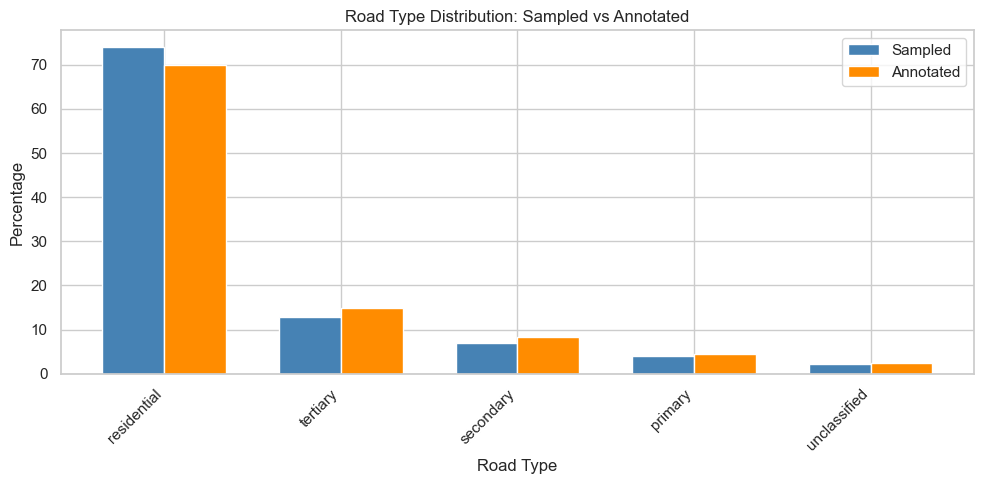

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
x = range(len(road_comparison))
width = 0.35
road_labels = road_comparison.index.tolist()

ax.bar([i - width/2 for i in x], road_comparison["sampled_pct"], width, label="Sampled", color="steelblue")
ax.bar([i + width/2 for i in x], road_comparison["annotated_pct"], width, label="Annotated", color="darkorange")
ax.set_ylabel("Percentage")
ax.set_xlabel("Road Type")
ax.set_title("Road Type Distribution: Sampled vs Annotated")
ax.set_xticks(x)
ax.set_xticklabels(road_labels, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "road_type_sampled_vs_annotated.png", dpi=150, bbox_inches="tight")
plt.show()

In [15]:
sampled_df = locations_df.dropna(subset=["lat", "lon"])
annotated_df = sampled_df[sampled_df["annotated"]]

center_lat = sampled_df["lat"].mean()
center_lon = sampled_df["lon"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

for _, row in sampled_df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=2,
        color="gray",
        fill=True,
        fill_opacity=0.3,
    ).add_to(m)

for _, row in annotated_df.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color="red",
        fill=True,
        fill_opacity=0.7,
    ).add_to(m)

m.save(str(OUTPUT_DIR / "sampled_vs_annotated_map.html"))
print(f"Saved map to {OUTPUT_DIR / 'sampled_vs_annotated_map.html'}")
print("Gray = sampled, Red = annotated")
m

Saved map to outputs/sampled_vs_annotated_map.html
Gray = sampled, Red = annotated


## Section 4: Summary Table

In [16]:
print("=" * 60)
print("PIPELINE SUMMARY")
print("=" * 60)
print(f"\nTotal sampled locations: {len(locations_df):,}")
print(f"Locations with Street View coverage: {locations_df['has_coverage'].sum():,} ({locations_df['has_coverage'].mean()*100:.1f}%)")
print(f"Locations annotated: {locations_df['annotated'].sum():,} ({locations_df['annotated'].mean()*100:.1f}%)")
print("\n" + "=" * 60)
print("BY CITY")
print("=" * 60)
print(funnel_by_city.to_string())
print("\n" + "=" * 60)
print("ROAD TYPE BIAS CHECK")
print("=" * 60)
print(road_comparison.to_string())

PIPELINE SUMMARY

Total sampled locations: 7,000
Locations with Street View coverage: 3,551 (50.7%)
Locations annotated: 1,435 (20.5%)

BY CITY
             sampled  with_coverage  annotated  coverage_rate  annotation_rate
city                                                                          
Delhi           2500           1171        500           46.8             42.7
Mumbai          2500           1246        498           49.8             40.0
Navi Mumbai     2000           1134        437           56.7             38.5

ROAD TYPE BIAS CHECK
              sampled_pct  annotated_pct  diff
osm_type                                      
residential          74.1           69.9  -4.2
tertiary             12.9           15.0   2.1
secondary             6.9            8.4   1.5
primary               4.0            4.4   0.4
unclassified          2.2            2.4   0.2


In [17]:
funnel_by_city.to_csv(OUTPUT_DIR / "pipeline_funnel_by_city.csv")
road_comparison.to_csv(OUTPUT_DIR / "road_type_bias_check.csv")
print(f"Saved pipeline summary to {OUTPUT_DIR}")

Saved pipeline summary to outputs
